# Few-shot-learning using resnet50 pretrained model

In [1]:
!git clone https://github.com/mirna-k/few-shot-learning-project.git

Cloning into 'few-shot-learning-project'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (500/500), done.
remote: Compressing objects: 100% (497/497), done.
remote: Total 500 (delta 6), reused 491 (delta 2), pack-reused 0
Receiving objects: 100% (500/500), 5.77 MiB | 16.77 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
%cd few-shot-learning-project/

/content/few-shot-learning-project


In [3]:
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

import matplotlib.pyplot as plt
from PIL import Image

from easyFSL_helper import *

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda
Device cuda


In [4]:
dataset_path = 'animals_dataset'
labelmap_path = 'animals_label_map.json'

N = 5 # n_classes
K = 5  # n_support_images
n_query = 10

In [5]:
val_transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
class ClassData:
    def __init__(self, support_dir, query_dir, class_name, label, cro_name, description, transform=None):
        self.class_name = class_name
        self.label = label
        self.cro_name = cro_name
        self.description = description
        self.images = []

        support_images_paths = [os.path.join(support_dir, filename) for filename in os.listdir(support_dir)]
        query_images_paths = [os.path.join(query_dir, filename) for filename in os.listdir(query_dir)]

        for image_path in support_images_paths:
            image = Image.open(image_path)
            if transform:
                image = transform(image)
            self.images.append(image)

        for image_path in query_images_paths:
            image = Image.open(image_path)
            if transform:
                image = transform(image)
            self.images.append(image)

        self.images = torch.stack(self.images)
        self.len = len(self.images)

    def __len__(self):
        return self.len

    @classmethod
    def get_class_data(cls, dataset_dir, class_label_map_json, transform=None):
        sets = {}

        with open(class_label_map_json, 'r') as f:
            class_label_map = json.load(f)

        for class_name, attributes in class_label_map.items():
            label = attributes['label']
            cro_name = attributes['cro_name']
            description = attributes['description']

            class_dir = os.path.join(dataset_dir, class_name)
            if os.path.isdir(class_dir):
                support_dir = os.path.join(class_dir, "support")
                query_dir = os.path.join(class_dir, "query")
                sets[label] = cls(support_dir, query_dir, class_name, label, cro_name, description, transform)

        return sets


class CustomDataset(Dataset):
    def __init__(self, class_data):
        self.class_data = class_data
        self.images = []
        self.labels = []

        for label, data in class_data.items():
            self.images.extend(data.images)
            self.labels.extend([label] * len(data))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [14]:
batch_size = 128

class_data = ClassData.get_class_data(dataset_path, labelmap_path, val_transform)
dataset = CustomDataset(class_data)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet = nn.Sequential(*list(resnet.children())[:-1])

flatten_layer = nn.Flatten()

model = nn.Sequential(
    resnet,
    flatten_layer
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [15]:
embeddings_df = predict_embeddings(data_loader, model, device=device)

print(embeddings_df.head())

Predicting embeddings:   0%|          | 0/3 [00:00<?, ?batch/s]

                                           embedding  class_name
0  [tensor(0.0956), tensor(0.2941), tensor(0.1358...           0
1  [tensor(0.3959), tensor(0.5061), tensor(0.0886...           0
2  [tensor(0.0360), tensor(0.5904), tensor(0.2335...           0
3  [tensor(0.6029), tensor(0.3076), tensor(0.8612...           0
4  [tensor(0.1395), tensor(0.0871), tensor(0.8310...           0


In [16]:
features_dataset = FeaturesDataset.from_dataframe(embeddings_df)

In [17]:
task_sampler = TaskSampler(features_dataset, n_way=N, n_shot=K, n_query=n_query, n_tasks=100)

features_loader = DataLoader(features_dataset, batch_sampler=task_sampler, pin_memory=True, collate_fn=task_sampler.episodic_collate_fn)

In [18]:
few_shot_classifier = PrototypicalNetworks(backbone=nn.Identity())

In [19]:
accuracy, macro_precision, macro_recall = evaluate(few_shot_classifier, features_loader, device="cpu")

print(f"Average accuracy : {(100 * accuracy):.6f} %\nMacro precision: {(100 * macro_precision):.6f}%\nMacro recall: {(100 * macro_recall):.6f}%")

  0%|          | 0/100 [00:00<?, ?it/s]

Average accuracy : 92.700000 %
Macro precision: 92.745698%
Macro recall: 92.700000%


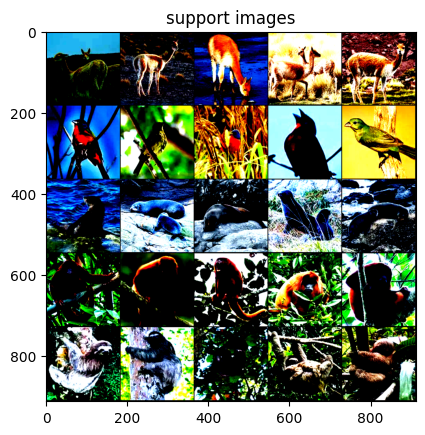

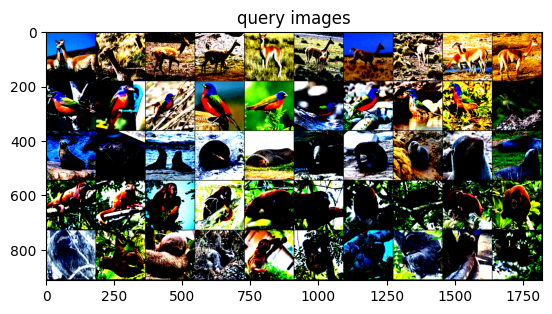

In [20]:
import torchvision

def plot_images(images: Tensor, title: str, images_per_row: int):
    plt.figure()
    plt.title(title)
    plt.imshow(torchvision.utils.make_grid(images, nrow=images_per_row).permute(1, 2, 0))


dataset.get_labels = lambda: [instance for instance in dataset.labels]

task_sampler = TaskSampler(dataset, n_way=N, n_shot=K, n_query=n_query, n_tasks=100)
support_loader =  DataLoader(dataset, batch_sampler=task_sampler, pin_memory=True, collate_fn=task_sampler.episodic_collate_fn)

(support_images, support_labels, query_images, query_labels, class_ids,) = next(iter(support_loader))

plot_images(support_images, "support images", images_per_row=K)
plot_images(query_images, "query images", images_per_row=n_query)